In [40]:
import numpy as np
import scipy as sp
from skimage.draw import line_nd
import cv2
from copy import deepcopy
from matplotlib import pyplot as plt
from ipywidgets import interact


### Wczytanie obrazu i parametrów

In [41]:

input_img = plt.imread("./example_photos/kropka.jpg")
# if len(np.shape(input_img)) == 3:
#     input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)


def parameter1(scans):
    return scans


def parameter2(detectors):
    return detectors


def parameter3(opening):
    return opening


interact(parameter1, scans=(90, 720, 45))
interact(parameter2, detectors=(90, 720, 90))
interact(parameter3, opening=(45, 270, 45))

scans = 90
detectors = 180
opening = 135

print("Scans:", scans)
print("Detectors:", detectors)
print("Opening:", opening)


interactive(children=(IntSlider(value=405, description='scans', max=720, min=90, step=45), Output()), _dom_cla…

interactive(children=(IntSlider(value=360, description='detectors', max=720, min=90, step=90), Output()), _dom…

interactive(children=(IntSlider(value=135, description='opening', max=270, min=45, step=45), Output()), _dom_c…

Scans: 90
Detectors: 180
Opening: 135


### Opisanie okręgu na obrazie

In [42]:
# Image shape
img_heigth, img_width, _ = np.shape(input_img)
print("Shape:", img_heigth, img_width)

# Center of mass
cx = int(img_heigth / 2)
cy = int(img_width / 2)
print("Center:", cx, cy)

# Radius
radius = int(np.floor(0.5 * np.sqrt(img_heigth**2 + img_width**2)))
print("Radius:", radius)


Shape: 400 400
Center: 200 200
Radius: 282


### Tworzenie sinogramu

(90, 180, 3)


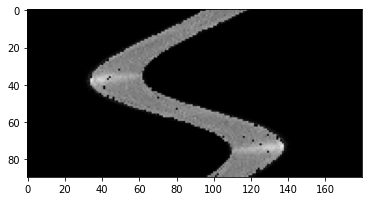

In [43]:
alpha = 360 / scans
step = alpha
n = detectors
l = opening

shots = []
E = []
D = []

sinogram = []

for _ in range(scans):
    shots.append(deepcopy(input_img))
    
    # Calculating emiter's position
    xe = radius * np.cos(np.deg2rad(alpha))
    # xe = int(np.floor(xe))
    ye = radius * np.sin(np.deg2rad(alpha))
    # ye = int(np.floor(ye))
    
    E.append((cx - xe, cy - ye))

    # Drawing emiter on an image
    # cv2.circle(shots[-1], E[-1], 7, (0, 255, 0), 3)

    D.append([])
    sinogram.append([])

    for i in range(n):
        # Calculating detector's position
        xd = radius * np.cos(np.deg2rad(alpha + np.pi - l / 2 + i * (l / (n-1))))
        # xd = int(np.floor(xd))
        yd = radius * np.sin(np.deg2rad(alpha + np.pi - l / 2 + i * (l / (n-1))))
        # yd = int(np.floor(yd))
        D[-1].append((xd + cx, yd + cy))

        # Drawing detector on the image
        # cv2.circle(shots[-1], D[-1][-1], 3, (255, 0, 0), 1)
        
        # Calculating points of the line
        line_x_points, line_y_points = line_nd(E[-1], D[-1][-1])
        
        brightness = 0
        sumof = 0
        
        for (x, y) in zip (line_x_points, line_y_points):
            # Drawing line on the image
            # cv2.circle(shots[-1], (x,y), 0, (0, 0, 255), -1)
            
            # Calculating mean brightness
            if x >= 0 and x < img_width and y >= 0 and y < img_heigth:
                brightness += input_img[x][y]
                sumof += 1
                
        # Adding results to sinogram
       
        brightness = brightness / sumof
        sinogram[-1].append(brightness)
            
    alpha += step
    

print(np.shape(sinogram))
plt.imshow(sinogram)
plt.show()

# for img in shots:
#     plt.imshow(img)
#     plt.show()


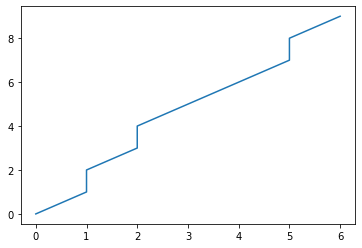

In [44]:
start = (0, 0)
stop = (6.7, 10.2)
x, y = line_nd(start, stop)
plt.plot(x, y)
